# Import

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from keras import Model, Sequential, layers, regularizers, optimizers
from keras.callbacks import EarlyStopping
from overcome_tomorrow.utils.data import *
from overcome_tomorrow.ml_logic.preprocess import *
from overcome_tomorrow.ml_logic.model import *
from tqdm import tqdm
pd.set_option('display.max_columns', None)
from sklearn import set_config; set_config(display='diagram')

2024-03-27 04:54:48.632083: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 04:54:48.736123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load DATA

In [6]:
garmin_data, activities = get_data()


⌛ Loading activities data from BigQuery server... ⌛ 
✅ activities data loaded, with shape (3363, 35)

⌛ Loading garmin_data data from BigQuery server... ⌛ 
✅ garmin_data data loaded, with shape (3445, 53)


In [19]:
activities.describe()

,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,total_descent,total_distance,pool_length,178,total_calories,max_cadence,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power
count,3358.000000,3361.000000,332.000000,3358.000000,317.000000,714.000000,3356.000000,2392.000000,3361.000000,317.000000,2975.000000,3363.000000,2142.000000,3363.000000,437.000000,2788.000000,755.000000,317.000000,755.000000,755.000000,594.000000,3363.000000,2392.000000,594.000000,923.000000,382.000000,2459.000000,3356.000000,594.000000
mean,0.119476,3.614168,0.200904,1.833055,106.962145,95.561625,135.716627,94.132107,15579.754228,28.548896,570.415798,573.460006,87.942110,1.279215,1375.368879,6.189855,94.554967,106.996845,67.666225,67.034437,260.314815,60.696527,95.251672,255.329966,4975.708559,107.610471,66.713298,115.615018,454.400673
std,0.337678,3.345774,0.687254,1.464344,39.990408,4.384690,27.428289,107.279476,20509.118434,8.738916,483.615289,519.539192,21.011961,1.207602,103.822065,5.270177,8.979823,39.944938,13.911137,14.077519,67.737144,67.004178,105.474575,69.607879,3707.651267,59.848741,22.684815,28.506462,111.467451
min,0.000000,0.000000,0.000000,0.000000,0.000000,86.000000,55.000000,0.000000,0.000000,25.000000,0.000000,0.000000,29.000000,0.000000,809.500000,0.000000,46.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,0.000000
25%,0.000000,0.649000,0.000000,0.300000,80.000000,93.000000,114.000000,21.000000,2089.090000,25.000000,197.000000,121.000000,63.000000,0.000000,1346.000000,2.034000,94.000000,80.000000,60.000000,60.000000,215.000000,4.338448,24.000000,210.000000,2022.500000,56.600000,53.000000,89.750000,391.250000
50%,0.000000,1.747000,0.000000,2.200000,116.000000,95.000000,142.000000,61.000000,6018.420000,25.000000,481.000000,493.000000,94.000000,2.000000,1398.200000,4.581000,99.000000,116.000000,68.000000,68.000000,233.000000,38.383881,63.000000,229.000000,3426.000000,112.500000,74.000000,124.000000,467.000000
75%,0.000000,6.666000,0.000000,3.100000,132.000000,97.000000,158.000000,133.000000,21031.920000,25.000000,797.500000,869.000000,101.750000,2.000000,1443.700000,10.964000,100.000000,132.000000,76.000000,76.000000,338.750000,100.929573,135.000000,336.750000,7643.000000,152.100000,88.000000,139.000000,514.000000
max,3.700000,10.537000,8.700000,5.000000,200.000000,127.000000,201.000000,1088.000000,161006.940000,50.000000,5800.000000,3517.000000,230.000000,7.000000,1542.800000,65.399000,100.000000,200.000000,100.000000,100.000000,408.000000,403.552704,1115.000000,406.000000,21131.000000,334.400000,95.000000,185.000000,1410.000000


# filter data per activity type

In [7]:
filters = {
    "sport": ["cycling", "running", "swimming"]
}

In [8]:
sport_filter = ["cycling", "running", "swimming"]

In [9]:
filtered_activities = activities[activities["sport"].isin(sport_filter)]
filtered_activities.tail(10)

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
3349,2024-03-11 18:17:41+00:00,0.0,3.999,NaN,3.1,NaN,91.0,155.0,generic,31.0,2024-03-11 17:34:32+00:00,10276.66,NaN,689.0,596.0,91.0,running,2.0,1415.9,4.507,69.0,NaN,50.0,50.0,None,354.0,97.694046,32.0,350.0,NaN,NaN,84.0,138.0,466.0,nicko64@hotmail.fr_240665171225
3351,2024-03-12 07:23:28+00:00,0.0,9.075,NaN,3.2,NaN,NaN,130.0,virtual_activity,234.0,2024-03-12 05:19:43+00:00,67182.03,NaN,1449.0,1805.0,120.0,cycling,3.0,NaN,13.427,88.0,NaN,66.0,66.0,None,223.0,114.251968,213.0,221.0,9360.0,131.5,76.0,116.0,356.0,nicko64@hotmail.fr_240769117539
3352,2024-03-12 07:34:08+00:00,0.0,5.654,NaN,1.5,NaN,NaN,141.0,indoor_cycling,NaN,2024-03-12 07:23:57+00:00,3401.64,NaN,158.0,173.0,81.0,cycling,1.0,NaN,6.392,66.0,NaN,62.0,61.0,None,266.0,22.180191,NaN,264.0,741.0,14.6,73.0,127.0,320.0,nicko64@hotmail.fr_240770883882
3353,2024-03-12 18:46:59+00:00,0.0,4.215,NaN,3.8,NaN,94.0,164.0,generic,42.0,2024-03-12 17:44:05+00:00,15179.46,NaN,999.0,888.0,94.0,running,3.0,1475.6,4.945,78.0,NaN,44.0,44.0,None,365.0,172.981277,44.0,363.0,NaN,NaN,85.0,147.0,464.0,nicko64@hotmail.fr_240860374328
3355,2024-03-13 07:49:03+00:00,0.0,8.869,NaN,3.5,NaN,NaN,141.0,gravel_cycling,288.0,2024-03-13 05:35:17+00:00,70631.01,NaN,1202.0,1930.0,99.0,cycling,3.0,NaN,11.617,91.0,NaN,63.0,63.0,None,223.0,146.113831,288.0,220.0,9964.0,142.2,75.0,126.0,390.0,nicko64@hotmail.fr_240966169031
3356,2024-03-13 18:54:11+00:00,0.0,4.022,NaN,3.3,NaN,91.0,159.0,generic,52.0,2024-03-13 17:43:45+00:00,16341.00,NaN,1128.0,943.0,91.0,running,2.0,1427.0,4.721,77.0,NaN,53.0,53.0,None,340.0,125.475555,54.0,338.0,NaN,NaN,84.0,141.0,431.0,nicko64@hotmail.fr_241056055877
3357,2024-03-14 07:52:39+00:00,0.0,8.895,NaN,3.7,NaN,NaN,138.0,gravel_cycling,284.0,2024-03-14 05:39:29+00:00,70766.39,NaN,962.0,1953.0,111.0,cycling,3.0,NaN,11.785,93.0,NaN,61.0,61.0,None,226.0,164.412140,285.0,223.0,9939.0,145.2,75.0,129.0,379.0,nicko64@hotmail.fr_241159952127
3359,2024-03-14 18:32:31+00:00,0.0,3.955,NaN,3.3,NaN,90.0,153.0,generic,52.0,2024-03-14 17:21:40+00:00,16012.68,NaN,1124.0,929.0,90.0,running,2.0,1404.1,4.283,94.0,NaN,71.0,71.0,None,339.0,116.148071,56.0,338.0,NaN,NaN,84.0,142.0,413.0,nicko64@hotmail.fr_241246052903
3360,2024-03-15 07:45:23+00:00,0.0,8.657,NaN,3.5,NaN,NaN,142.0,gravel_cycling,298.0,2024-03-15 05:25:09+00:00,72616.84,NaN,1371.0,2019.0,104.0,cycling,3.0,NaN,11.915,95.0,NaN,67.0,67.0,None,221.0,144.809784,296.0,218.0,10737.0,147.4,77.0,127.0,418.0,nicko64@hotmail.fr_241349530713
3362,2024-03-15 11:26:17+00:00,0.0,3.521,NaN,1.5,NaN,88.0,139.0,generic,13.0,2024-03-15 11:14:42+00:00,2337.73,NaN,184.0,140.0,88.0,running,1.0,1265.6,4.749,95.0,NaN,91.0,91.0,None,323.0,22.125320,16.0,319.0,NaN,NaN,84.0,126.0,442.0,nicko64@hotmail.fr_241377639543


<AxesSubplot:ylabel='Frequency'>

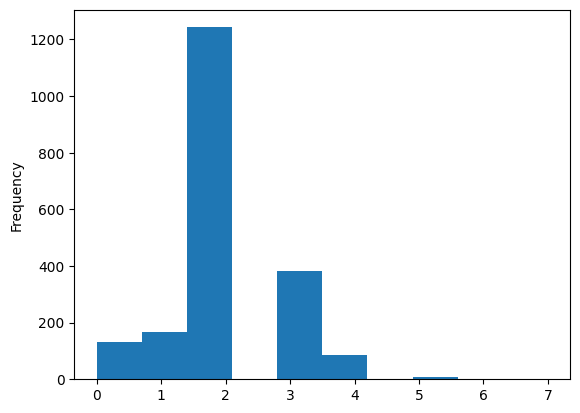

In [7]:
filtered_activities["188"].plot.hist()

In [8]:
filtered_activities[filtered_activities["188"] == 0]

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
283,2020-01-25 12:56:36+00:00,NaN,0.720,0.0,NaN,46.0,NaN,70.0,lap_swimming,NaN,2020-01-25 12:03:07+00:00,2300.00,50.0,NaN,561.0,NaN,swimming,0.0,NaN,2.326,NaN,46.0,NaN,NaN,metric,NaN,0.000000,NaN,NaN,1308.0,NaN,25.0,70.0,NaN,nicko64@hotmail.fr_48105747053
548,2020-05-20 11:01:54+00:00,0.0,6.608,NaN,0.5,NaN,NaN,121.0,mountain,28.0,2020-05-20 10:44:27+00:00,6795.57,NaN,193.0,134.0,NaN,cycling,0.0,NaN,8.286,NaN,NaN,NaN,NaN,None,NaN,7.540970,28.0,NaN,NaN,NaN,NaN,108.0,NaN,nicko64@hotmail.fr_56336749795
578,2020-05-30 19:49:54+00:00,0.0,5.699,NaN,0.7,NaN,NaN,129.0,generic,31.0,2020-05-30 19:21:14+00:00,9760.52,NaN,320.0,200.0,NaN,cycling,0.0,NaN,6.746,NaN,NaN,NaN,NaN,None,NaN,9.734558,36.0,NaN,NaN,NaN,NaN,108.0,NaN,nicko64@hotmail.fr_57237023632
611,2020-06-13 16:03:09+00:00,0.0,6.616,NaN,0.5,NaN,NaN,129.0,generic,114.0,2020-06-13 15:49:44+00:00,5252.37,NaN,130.0,106.0,NaN,cycling,0.0,NaN,12.400,NaN,NaN,NaN,NaN,None,NaN,7.150574,41.0,NaN,NaN,NaN,NaN,111.0,NaN,nicko64@hotmail.fr_58442051290
625,2020-06-19 16:16:23+00:00,0.0,6.602,NaN,0.8,NaN,NaN,124.0,generic,107.0,2020-06-19 15:34:23+00:00,16332.27,NaN,456.0,274.0,NaN,cycling,0.0,NaN,7.959,NaN,NaN,NaN,NaN,None,NaN,10.853607,34.0,NaN,NaN,NaN,NaN,106.0,NaN,nicko64@hotmail.fr_58977911734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,2023-08-28 09:14:22+00:00,0.0,0.686,0.0,0.6,24.0,NaN,137.0,lap_swimming,NaN,2023-08-28 08:55:38+00:00,600.00,25.0,NaN,109.0,NaN,swimming,0.0,NaN,1.042,NaN,24.0,NaN,NaN,metric,NaN,9.028412,NaN,NaN,288.0,NaN,20.0,110.0,NaN,nicko64@hotmail.fr_206714877913
2801,2023-08-28 16:42:47+00:00,0.0,8.861,NaN,0.8,NaN,NaN,117.0,indoor_cycling,NaN,2023-08-28 16:32:40+00:00,5322.09,NaN,121.0,135.0,107.0,cycling,0.0,NaN,9.144,100.0,NaN,98.0,98.0,None,205.0,12.101959,NaN,202.0,794.0,11.0,79.0,110.0,229.0,nicko64@hotmail.fr_206768535768
2875,2023-10-01 12:53:22+00:00,0.0,0.235,8.7,0.0,NaN,NaN,109.0,open_water,NaN,2023-10-01 12:48:55+00:00,52.19,NaN,22.0,16.0,29.0,swimming,0.0,NaN,0.620,NaN,NaN,NaN,NaN,None,NaN,0.717346,NaN,NaN,6.0,NaN,1.0,90.0,NaN,nicko64@hotmail.fr_212574354598
3217,2024-02-03 16:27:19+00:00,0.0,6.469,NaN,0.4,NaN,NaN,136.0,road,5.0,2024-02-03 16:20:32+00:00,2516.03,NaN,37.0,64.0,136.0,cycling,0.0,NaN,10.170,63.0,NaN,62.0,62.0,None,163.0,5.913086,22.0,143.0,428.0,3.3,73.0,119.0,325.0,nicko64@hotmail.fr_233781904268


In [14]:
filtered_activities_dict = {sport: activities[activities["sport"].isin([sport])].reset_index(drop=True) for sport in sport_filter}

# Train on subset data

In [ ]:
for sport, sport_activities in filtered_activities_dict.items():
    model_filename = f"{sport}_{MODEL_NAME}"
    #Small hack for swimming to avoid preprocessor to throw an error.
    if sport in ("simming", "walking"):
        sport_activities["205"] = 100
    create_train_and_save_model_for_data(garmin_data=garmin_data, activities=sport_activities, model_filename=model_filename)

In [21]:
for sport, sport_activities in filtered_activities_dict.items():
    model_filename = f"{sport}_base_model_2.keras"
    print(sport)
    #Small hack for swimming to avoid preprocessor to throw an error.
    if sport in ("swimming"):
        sport_activities["205"] = 100
        create_train_and_save_model_for_data(garmin_data=garmin_data, activities=sport_activities, model_filename=model_filename)

cycling
running
swimming

👷‍♂️ Create and train model swimming_base_model_2.keras 👷‍♀️


⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:17<00:00, 15.72it/s]


Epoch 1/50
9/9 [==============================] - 4s 41ms/step - loss: 778.6871 - accuracy: 0.0037
Epoch 2/50
9/9 [==============================] - 0s 23ms/step - loss: 770.8294 - accuracy: 0.0184
Epoch 3/50
9/9 [==============================] - 0s 20ms/step - loss: 765.6750 - accuracy: 0.1029
Epoch 4/50
9/9 [==============================] - 0s 22ms/step - loss: 762.2677 - accuracy: 0.1397
Epoch 5/50
9/9 [==============================] - 0s 20ms/step - loss: 759.8760 - accuracy: 0.0846
Epoch 6/50
9/9 [==============================] - 0s 21ms/step - loss: 755.8868 - accuracy: 0.0956
Epoch 7/50
9/9 [==============================] - 0s 21ms/step - loss: 755.2767 - accuracy: 0.0809
Epoch 8/50
9/9 [==============================] - 0s 24ms/step - loss: 753.8295 - accuracy: 0.1213
Epoch 9/50
9/9 [==============================] - 0s 23ms/step - loss: 753.7639 - accuracy: 0.1140
Epoch 10/50
9/9 [==============================] - 0s 20ms/step - loss: 751.7661 - accuracy: 0.1471
Epoch 11/

# Load sub model/preprocessors

In [11]:
for sport, sport_activities in filtered_activities_dict.items():
    # model_filename = f"{sport}_{MODEL_NAME}"
    model_filename = f"{sport}_mse_model.keras"
    preproc_garmin_data, preproc_activity, model = load_preprocessors_and_model(model_filename=model_filename)
    a = sport_activities.tail(3)
    t = preproc_activity.transform(sport_activities.tail(3))
    display(a)
    display(t)
    display(preproc_activity.inverse_transform(t))

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
973,2024-03-13 07:49:03+00:00,0.0,8.869,NaN,3.5,NaN,NaN,141.0,gravel_cycling,288.0,2024-03-13 05:35:17+00:00,70631.01,NaN,1202.0,1930.0,99.0,cycling,3.0,NaN,11.617,91.0,NaN,63.0,63.0,None,223.0,146.113831,288.0,220.0,9964.0,142.2,75.0,126.0,390.0,nicko64@hotmail.fr_240966169031
974,2024-03-14 07:52:39+00:00,0.0,8.895,NaN,3.7,NaN,NaN,138.0,gravel_cycling,284.0,2024-03-14 05:39:29+00:00,70766.39,NaN,962.0,1953.0,111.0,cycling,3.0,NaN,11.785,93.0,NaN,61.0,61.0,None,226.0,164.412140,285.0,223.0,9939.0,145.2,75.0,129.0,379.0,nicko64@hotmail.fr_241159952127
975,2024-03-15 07:45:23+00:00,0.0,8.657,NaN,3.5,NaN,NaN,142.0,gravel_cycling,298.0,2024-03-15 05:25:09+00:00,72616.84,NaN,1371.0,2019.0,104.0,cycling,3.0,NaN,11.915,95.0,NaN,67.0,67.0,None,221.0,144.809784,296.0,218.0,10737.0,147.4,77.0,127.0,418.0,nicko64@hotmail.fr_241349530713


,knn_imputer__total_ascent,knn_imputer__207,knn_imputer__total_training_effect,knn_imputer__max_heart_rate,knn_imputer__178,knn_imputer__avg_heart_rate,knn_imputer__training_load_peak,knn_imputer__206,knn_imputer__total_calories,knn_imputer__total_anaerobic_training_effect,knn_imputer__missingindicator_total_ascent,knn_imputer__missingindicator_207,knn_imputer__missingindicator_total_training_effect,knn_imputer__missingindicator_max_heart_rate,knn_imputer__missingindicator_178,knn_imputer__missingindicator_avg_heart_rate,knn_imputer__missingindicator_206,knn_imputer__missingindicator_total_anaerobic_training_effect,function_transformer_max_speed__enhanced_max_speed,function_transformer_max_speed__enhanced_avg_speed,imputer_100__205,188_label_primary__188_Base,188_label_primary__188_None,188_label_primary__188_Recovery,188_label_primary__188_Speed,188_label_primary__188_Tempo,188_label_primary__188_Threshold,188_label_primary__188_VO2max,categorial_proces__sport_cycling,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos
973,0.992,-0.950495,0.8,-0.754717,0.896872,-0.583333,1.244778,-1.000000,1.510092,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-0.178643,0.067726,-9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.889017,-0.457874,0.994056,0.108867
974,0.968,-1.108911,1.0,-0.981132,0.491124,-0.333333,1.534666,-1.156863,1.541567,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-0.125050,0.085695,-7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.882948,-0.469472,0.995805,0.091502
975,1.056,-0.633663,0.8,-0.679245,1.182587,-0.500000,1.224119,-0.686275,1.631885,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-0.083579,-0.078784,-5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.896873,-0.442289,0.988362,0.152123


,total_ascent,207,total_training_effect,max_heart_rate,178,avg_heart_rate,training_load_peak,206,total_calories,total_anaerobic_training_effect,enhanced_max_speed,enhanced_avg_speed,205,188,sport,timestamp,start_time
0,288.0,63.0,3.5,141.0,1202.0,126.0,146.113831,63.0,1930.0,0.0,11.617,8.869,91.0,Tempo,cycling,7:49:00,5:35:00
1,285.0,61.0,3.7,138.0,962.0,129.0,164.412140,61.0,1953.0,0.0,11.785,8.895,93.0,Tempo,cycling,7:51:59,5:39:00
2,296.0,67.0,3.5,142.0,1371.0,127.0,144.809784,67.0,2019.0,0.0,11.915,8.657,95.0,Tempo,cycling,7:45:00,5:25:00


,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
711,2024-03-13 18:54:11+00:00,0.0,4.022,NaN,3.3,NaN,91.0,159.0,generic,52.0,2024-03-13 17:43:45+00:00,16341.00,NaN,1128.0,943.0,91.0,running,2.0,1427.0,4.721,77.0,NaN,53.0,53.0,None,340.0,125.475555,54.0,338.0,NaN,NaN,84.0,141.0,431.0,nicko64@hotmail.fr_241056055877
712,2024-03-14 18:32:31+00:00,0.0,3.955,NaN,3.3,NaN,90.0,153.0,generic,52.0,2024-03-14 17:21:40+00:00,16012.68,NaN,1124.0,929.0,90.0,running,2.0,1404.1,4.283,94.0,NaN,71.0,71.0,None,339.0,116.148071,56.0,338.0,NaN,NaN,84.0,142.0,413.0,nicko64@hotmail.fr_241246052903
713,2024-03-15 11:26:17+00:00,0.0,3.521,NaN,1.5,NaN,88.0,139.0,generic,13.0,2024-03-15 11:14:42+00:00,2337.73,NaN,184.0,140.0,88.0,running,1.0,1265.6,4.749,95.0,NaN,91.0,91.0,None,323.0,22.125320,16.0,319.0,NaN,NaN,84.0,126.0,442.0,nicko64@hotmail.fr_241377639543


,knn_imputer__total_ascent,knn_imputer__207,knn_imputer__total_training_effect,knn_imputer__max_heart_rate,knn_imputer__178,knn_imputer__avg_heart_rate,knn_imputer__training_load_peak,knn_imputer__206,knn_imputer__total_calories,knn_imputer__total_anaerobic_training_effect,knn_imputer__missingindicator_207,knn_imputer__missingindicator_max_heart_rate,knn_imputer__missingindicator_178,knn_imputer__missingindicator_avg_heart_rate,knn_imputer__missingindicator_206,function_transformer_max_speed__enhanced_max_speed,function_transformer_max_speed__enhanced_avg_speed,imputer_100__205,188_label_primary__188_Base,188_label_primary__188_None,188_label_primary__188_Recovery,188_label_primary__188_Tempo,188_label_primary__188_Threshold,188_label_primary__188_VO2max,categorial_proces__sport_running,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos
711,-0.503311,-1.352273,-0.428571,-0.636364,0.822099,-0.888889,-0.243556,-1.403509,0.187583,0.0,-1.0,0.0,0.0,0.0,-1.0,0.136729,-0.386646,-23.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.972370,0.233445,-0.997250,-0.074108
712,-0.450331,0.284091,-0.428571,-1.181818,0.813260,-0.777778,-0.364159,0.280702,0.150594,0.0,-1.0,0.0,0.0,0.0,-1.0,-1.037534,-0.594720,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.990268,0.139173,-0.985556,-0.169350
713,-1.509934,2.102273,-3.000000,-2.454545,-1.264088,-2.555556,-1.579865,2.152047,-1.933950,0.0,-1.0,0.0,0.0,0.0,-1.0,0.211796,-1.942547,-5.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.147809,-0.989016,0.199368,-0.979925


,total_ascent,207,total_training_effect,max_heart_rate,178,avg_heart_rate,training_load_peak,206,total_calories,total_anaerobic_training_effect,enhanced_max_speed,enhanced_avg_speed,205,188,sport,timestamp,start_time
0,54.0,53.0,3.3,159.0,1128.0,141.0,125.475555,53.0,943.0,0.0,4.721,4.022,77.0,Base,running,18:53:59,17:43:59
1,56.0,71.0,3.3,153.0,1124.0,142.0,116.148071,71.0,929.0,0.0,4.283,3.955,94.0,Base,running,18:32:00,17:21:00
2,16.0,91.0,1.5,139.0,184.0,126.0,22.125320,91.0,140.0,0.0,4.749,3.521,95.0,Recovery,running,11:26:00,11:14:00


,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_running_cadence,max_heart_rate,sub_sport,total_descent,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,avg_step_length,enhanced_max_speed,205,num_lengths,206,207,pool_length_unit,normalized_power,training_load_peak,total_ascent,avg_power,total_strokes,training_stress_score,avg_cadence,avg_heart_rate,max_power,activity_id
329,2024-02-17 10:02:01+00:00,0.0,0.578,0.0,2.4,152.0,NaN,137.0,lap_swimming,NaN,2024-02-17 08:11:50+00:00,3800.0,25.0,NaN,840.0,NaN,swimming,2.0,NaN,2.062,NaN,152.0,NaN,NaN,metric,NaN,52.170517,NaN,NaN,2726.0,NaN,25.0,125.0,NaN,nicko64@hotmail.fr_236285541286
330,2024-02-19 07:34:12+00:00,0.0,0.544,0.0,2.1,59.0,NaN,142.0,lap_swimming,NaN,2024-02-19 06:47:43+00:00,1475.0,25.0,NaN,338.0,NaN,swimming,2.0,NaN,0.669,NaN,60.0,NaN,NaN,metric,NaN,38.211884,NaN,NaN,1121.0,NaN,25.0,127.0,NaN,nicko64@hotmail.fr_236643866931
331,2024-03-09 09:47:30+00:00,0.0,0.578,0.0,2.1,60.0,NaN,143.0,lap_swimming,NaN,2024-03-09 09:01:40+00:00,1500.0,25.0,NaN,354.0,NaN,swimming,1.0,NaN,0.710,NaN,60.0,NaN,NaN,metric,NaN,34.587540,NaN,NaN,1074.0,NaN,25.0,125.0,NaN,nicko64@hotmail.fr_240209471766


,knn_imputer__total_training_effect,knn_imputer__max_heart_rate,knn_imputer__178,knn_imputer__avg_heart_rate,knn_imputer__training_load_peak,knn_imputer__total_calories,knn_imputer__total_anaerobic_training_effect,knn_imputer__missingindicator_total_training_effect,knn_imputer__missingindicator_178,knn_imputer__missingindicator_total_anaerobic_training_effect,function_transformer_max_speed__enhanced_max_speed,function_transformer_max_speed__enhanced_avg_speed,imputer_100__205,188_label_primary__188_Base,188_label_primary__188_None,188_label_primary__188_Recovery,188_label_primary__188_Tempo,categorial_proces__sport_swimming,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos
329,0.0,-0.6875,0.00,-0.377358,-0.040706,1.061728,0.0,0.0,0.0,0.0,3.115638,-0.558333,0.0,1.0,0.0,0.0,0.0,1.0,0.492424,-0.870356,0.841039,-0.540974
330,-0.5,-0.3750,-158.25,-0.226415,-0.390073,-1.417284,0.0,0.0,0.0,0.0,-0.222888,-1.125000,0.0,1.0,0.0,0.0,0.0,1.0,0.917060,-0.398749,0.979045,-0.203642
331,-0.5,-0.3125,-39.50,-0.377358,-0.480785,-1.338272,0.0,0.0,0.0,0.0,-0.124626,-0.558333,0.0,0.0,0.0,1.0,0.0,1.0,0.548293,-0.836286,0.704015,-0.710185


,total_training_effect,max_heart_rate,178,avg_heart_rate,training_load_peak,total_calories,total_anaerobic_training_effect,enhanced_max_speed,enhanced_avg_speed,205,188,sport,timestamp,start_time
0,2.4,137.0,702.50,125.0,52.170517,840.0,0.0,2.062,0.578,100.0,Base,swimming,10:02:00,8:11:00
1,2.1,142.0,544.25,127.0,38.211884,338.0,0.0,0.669,0.544,100.0,Base,swimming,7:34:00,6:47:00
2,2.1,143.0,663.00,125.0,34.587540,354.0,0.0,0.710,0.578,100.0,Recovery,swimming,9:47:00,9:01:00


# Test preprocessor inverter on submodel

In [24]:
test_preproc

InvertableColumnTransformer(transformers=[('knn_imputer',
                                           Pipeline(steps=[('knn_imputer',
                                                            KNNImputer(add_indicator=True,
                                                                       n_neighbors=4)),
                                                           ('robust_scaler',
                                                            RobustScaler())]),
                                           ['total_calories', 'avg_heart_rate',
                                            'max_heart_rate',
                                            'total_anaerobic_training_effect',
                                            'training_load_peak', '178',
                                            'total_training_effect']),
                                          ('function_transformer_max_speed',
                                           Pipeline...
                                                            OneHotEncoder(drop='if_binary',
                                                                          handle_unknown='ignore',
                                                                          sparse_output=False))]),
                                           ['188']),
                                          ('categorial_proces',
                                           Pipeline(steps=[('simple_imputer',
                                                            SimpleImputer(strategy='most_frequent')),
                                                           ('one_hot',
                                                            OneHotEncoder(drop='if_binary',
                                                                          handle_unknown='ignore',
                                                                          sparse_output=False))]),
                                           ['sport']),
                                          ('cycle_encoder',
                                           CyclicalFeaturesActivity(),
                                           ['timestamp', 'start_time'])])

In [12]:
swimming = filtered_activities_dict["swimming"]
swimming["205"] = 100
swimming.dropna(axis = 1, how="all", inplace = True)
test_preproc = create_preproc_activity(swimming)
test_preproc.fit(swimming)
a = swimming.tail(3)
t = test_preproc.transform(swimming.tail(3))
display(a)
display(t)
display(test_preproc.inverse_transform(t))

,timestamp,total_anaerobic_training_effect,enhanced_avg_speed,avg_stroke_distance,total_training_effect,num_active_lengths,max_heart_rate,sub_sport,start_time,total_distance,pool_length,178,total_calories,max_cadence,sport,188,enhanced_max_speed,205,num_lengths,pool_length_unit,training_load_peak,total_strokes,avg_cadence,avg_heart_rate,activity_id
329,2024-02-17 10:02:01+00:00,0.0,0.578,0.0,2.4,152.0,137.0,lap_swimming,2024-02-17 08:11:50+00:00,3800.0,25.0,NaN,840.0,NaN,swimming,2.0,2.062,100,152.0,metric,52.170517,2726.0,25.0,125.0,nicko64@hotmail.fr_236285541286
330,2024-02-19 07:34:12+00:00,0.0,0.544,0.0,2.1,59.0,142.0,lap_swimming,2024-02-19 06:47:43+00:00,1475.0,25.0,NaN,338.0,NaN,swimming,2.0,0.669,100,60.0,metric,38.211884,1121.0,25.0,127.0,nicko64@hotmail.fr_236643866931
331,2024-03-09 09:47:30+00:00,0.0,0.578,0.0,2.1,60.0,143.0,lap_swimming,2024-03-09 09:01:40+00:00,1500.0,25.0,NaN,354.0,NaN,swimming,1.0,0.710,100,60.0,metric,34.587540,1074.0,25.0,125.0,nicko64@hotmail.fr_240209471766


,knn_imputer__178,knn_imputer__total_anaerobic_training_effect,knn_imputer__total_calories,knn_imputer__total_training_effect,knn_imputer__max_heart_rate,knn_imputer__avg_heart_rate,knn_imputer__training_load_peak,knn_imputer__missingindicator_178,knn_imputer__missingindicator_total_anaerobic_training_effect,knn_imputer__missingindicator_total_training_effect,function_transformer_max_speed__enhanced_max_speed,function_transformer_max_speed__enhanced_avg_speed,imputer_100__205,188_label_primary__188_Base,188_label_primary__188_None,188_label_primary__188_Recovery,188_label_primary__188_Tempo,categorial_proces__sport_swimming,cycle_encoder__timestamp_sin,cycle_encoder__timestamp_cos,cycle_encoder__start_time_sin,cycle_encoder__start_time_cos
329,0.00,0.0,1.061728,0.0,-0.6875,-0.377358,-0.040706,0.0,0.0,0.0,3.115638,-0.558333,0.0,1.0,0.0,0.0,0.0,1.0,0.492424,-0.870356,0.841039,-0.540974
330,-158.25,0.0,-1.417284,-0.5,-0.3750,-0.226415,-0.390073,0.0,0.0,0.0,-0.222888,-1.125000,0.0,1.0,0.0,0.0,0.0,1.0,0.917060,-0.398749,0.979045,-0.203642
331,-39.50,0.0,-1.338272,-0.5,-0.3125,-0.377358,-0.480785,0.0,0.0,0.0,-0.124626,-0.558333,0.0,0.0,0.0,1.0,0.0,1.0,0.548293,-0.836286,0.704015,-0.710185


,178,total_anaerobic_training_effect,total_calories,total_training_effect,max_heart_rate,avg_heart_rate,training_load_peak,enhanced_max_speed,enhanced_avg_speed,205,188,sport,timestamp,start_time
0,702.50,0.0,840.0,2.4,137.0,125.0,52.170517,2.062,0.578,100.0,Base,swimming,10:02:00,8:11:00
1,544.25,0.0,338.0,2.1,142.0,127.0,38.211884,0.669,0.544,100.0,Base,swimming,7:34:00,6:47:00
2,663.00,0.0,354.0,2.1,143.0,125.0,34.587540,0.710,0.578,100.0,Recovery,swimming,9:47:00,9:01:00


# Test from python code

In [4]:
garmin_data, activities = get_data()
create_train_and_save_sports_sub_model_for_data(garmin_data=garmin_data, activities=activities, model_filename="base_model.keras")
create_train_and_save_model_for_data(garmin_data=garmin_data, activities=activities, model_filename="base_model.keras")


⌛ Loading activities data from BigQuery server... ⌛ 
✅ activities data loaded, with shape (3363, 35)

⌛ Loading garmin_data data from BigQuery server... ⌛ 
✅ garmin_data data loaded, with shape (3445, 53)

👷‍♂️ Create and train model cycling_base_model.keras 👷‍♀️


⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 916/916 [01:00<00:00, 15.21it/s]


Epoch 1/50


2024-03-27 05:06:26.087832: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-03-27 05:06:27.949000: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


26/26 [==============================] - 10s 69ms/step - loss: 1.4637 - accuracy: 0.0158 - val_loss: 5.7505 - val_accuracy: 0.0000e+00
Epoch 2/50
26/26 [==============================] - 1s 27ms/step - loss: 1.2697 - accuracy: 0.0400 - val_loss: 5.3210 - val_accuracy: 0.0000e+00
Epoch 3/50
26/26 [==============================] - 1s 29ms/step - loss: 1.2360 - accuracy: 0.0498 - val_loss: 5.1155 - val_accuracy: 0.0000e+00
Epoch 4/50
26/26 [==============================] - 1s 29ms/step - loss: 1.2200 - accuracy: 0.0583 - val_loss: 5.1122 - val_accuracy: 0.0000e+00
Epoch 5/50
26/26 [==============================] - 1s 25ms/step - loss: 1.2174 - accuracy: 0.0534 - val_loss: 5.1817 - val_accuracy: 0.0000e+00
Epoch 6/50
26/26 [==============================] - 1s 22ms/step - loss: 1.2032 - accuracy: 0.0437 - val_loss: 5.1845 - val_accuracy: 0.0000e+00
Epoch 7/50
26/26 [==============================] - 1s 25ms/step - loss: 1.1894 - accuracy: 0.0655 - val_loss: 5.0662 - val_accuracy: 0.0000

⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 654/654 [00:41<00:00, 15.82it/s]


Epoch 1/50
19/19 [==============================] - 5s 82ms/step - loss: 1.2337 - accuracy: 0.0918 - val_loss: 9.6489 - val_accuracy: 0.0000e+00
Epoch 2/50
19/19 [==============================] - 0s 25ms/step - loss: 1.0993 - accuracy: 0.0476 - val_loss: 8.6809 - val_accuracy: 0.0000e+00
Epoch 3/50
19/19 [==============================] - 1s 27ms/step - loss: 1.0664 - accuracy: 0.0374 - val_loss: 8.5405 - val_accuracy: 0.0000e+00
Epoch 4/50
19/19 [==============================] - 1s 27ms/step - loss: 1.0587 - accuracy: 0.0425 - val_loss: 8.5270 - val_accuracy: 0.0000e+00
Epoch 5/50
19/19 [==============================] - 1s 27ms/step - loss: 1.0483 - accuracy: 0.0255 - val_loss: 8.5040 - val_accuracy: 0.0000e+00
Epoch 6/50
19/19 [==============================] - 0s 26ms/step - loss: 1.0325 - accuracy: 0.0595 - val_loss: 8.2614 - val_accuracy: 0.3485
Epoch 7/50
19/19 [==============================] - 0s 23ms/step - loss: 1.0407 - accuracy: 0.0663 - val_loss: 8.2111 - val_accuracy: 

⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:16<00:00, 16.68it/s]


Epoch 1/50
8/8 [==============================] - 5s 172ms/step - loss: 863.2232 - accuracy: 0.0246 - val_loss: 51.5923 - val_accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 0s 31ms/step - loss: 855.7601 - accuracy: 0.0041 - val_loss: 50.7322 - val_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 0s 28ms/step - loss: 849.4015 - accuracy: 0.0041 - val_loss: 50.3686 - val_accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 0s 30ms/step - loss: 845.2208 - accuracy: 0.0000e+00 - val_loss: 50.1468 - val_accuracy: 0.0000e+00
Epoch 5/50
8/8 [==============================] - 0s 30ms/step - loss: 842.5767 - accuracy: 0.0246 - val_loss: 50.0951 - val_accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 0s 30ms/step - loss: 839.2250 - accuracy: 0.1352 - val_loss: 50.1469 - val_accuracy: 0.2857
Epoch 7/50
8/8 [==============================] - 0s 33ms/step - loss: 837.6965 - accuracy: 0.1844 - val_loss: 50.2106 - va

⌛ Creating Sliding Window dataset... ⌛: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [00:43<00:00, 16.95it/s]


Epoch 1/50
21/21 [==============================] - 5s 78ms/step - loss: 1.7440 - accuracy: 0.0635 - val_loss: 0.3993 - val_accuracy: 0.0000e+00
Epoch 2/50
21/21 [==============================] - 1s 29ms/step - loss: 1.6752 - accuracy: 0.2239 - val_loss: 0.3694 - val_accuracy: 0.0000e+00
Epoch 3/50
21/21 [==============================] - 1s 32ms/step - loss: 1.6642 - accuracy: 0.1513 - val_loss: 0.3631 - val_accuracy: 0.0541
Epoch 4/50
21/21 [==============================] - 1s 29ms/step - loss: 1.6517 - accuracy: 0.1604 - val_loss: 0.3647 - val_accuracy: 0.0811
Epoch 5/50
21/21 [==============================] - 1s 29ms/step - loss: 1.6472 - accuracy: 0.1483 - val_loss: 0.3588 - val_accuracy: 0.1351
Epoch 6/50
21/21 [==============================] - 1s 30ms/step - loss: 1.6392 - accuracy: 0.1528 - val_loss: 0.3598 - val_accuracy: 0.1216
Epoch 7/50
21/21 [==============================] - 1s 30ms/step - loss: 1.6292 - accuracy: 0.1256 - val_loss: 0.3700 - val_accuracy: 0.2568
Epoch

⌛ Creating Sliding Window dataset... ⌛: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3303/3303 [03:22<00:00, 16.31it/s]


Epoch 1/50
93/93 [==============================] - 7s 41ms/step - loss: 0.5492 - accuracy: 0.1763 - val_loss: 2.5552 - val_accuracy: 0.1662
Epoch 2/50
93/93 [==============================] - 3s 29ms/step - loss: 0.5236 - accuracy: 0.2133 - val_loss: 2.5446 - val_accuracy: 0.1601
Epoch 3/50
93/93 [==============================] - 3s 31ms/step - loss: 0.5129 - accuracy: 0.2227 - val_loss: 2.7659 - val_accuracy: 0.1027
Epoch 4/50
93/93 [==============================] - 3s 31ms/step - loss: 0.5102 - accuracy: 0.2160 - val_loss: 2.5646 - val_accuracy: 0.1480
Epoch 5/50
93/93 [==============================] - 3s 30ms/step - loss: 0.4983 - accuracy: 0.2207 - val_loss: 2.5771 - val_accuracy: 0.1057
Epoch 6/50
93/93 [==============================] - 3s 29ms/step - loss: 0.4946 - accuracy: 0.2103 - val_loss: 2.4986 - val_accuracy: 0.1420
Epoch 7/50
93/93 [==============================] - 3s 30ms/step - loss: 0.4902 - accuracy: 0.2180 - val_loss: 2.5919 - val_accuracy: 0.1964
Epoch 8/50
93